In [1]:
import cobra
import thermo_flux
from thermo_flux.core.model import ThermoModel, ThermoReaction
from equilibrator_api import  Q_

### Load the latest version of the plant core model from the bitbucket. (this is on the dev_Ed branch)
This model has been modified to remove the a, b, etc. prefixed form metabolites with different charge states. 
The full set of modifications can be seen in the notebook "PlantCoreMetabolism_v3_curation_02.ipynb" on the dev_Ed branch as well as in the CurationLog.csv
Major changes include removal of the mitochondrial intermembrane space compartment and modifcation of the phloem composition to match Arabidopsis data.

The model is already constrained to represent a leaf model during the day using the function "day_model()" which is in the file "curation.py" which also includes some other useful functions. These should be moved to the sweetlove bitbucket at some point... 

In [2]:
model = cobra.io.read_sbml_model(r"PlantCoreMetabolism_v3_0_1.xml")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18


At this point you might want to compare this model to any model you were using previously to see what any differences are. 

Things to look out for include cycles of NH3 and NH4 transport to move protons or issues around mitochondrial electron/proton transport

In [3]:
model.objective = model.reactions.Phloem_output_tx
sol = cobra.flux_analysis.pfba(model)
model.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
CARBON_DIOXIDE_e,CO2_tx,70.44,1,100.00%
WATER_e,H2O_tx,63.62,0,0.00%
PROTON_e,H_tx,3.253,0,0.00%
NITRATE_e,Nitrate_tx,3.446,0,0.00%
Photon_e,Photon_tx,1000,0,0.00%
SULFATE_e,SO4_tx,0.01593,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
OXYGEN_MOLECULE_e,O2_tx,-76.52,0,0.00%


## Convert the model to a ThermoModel to use the new proton balancing features

In [4]:
tmodel = ThermoModel(model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

### Define the physiological properties of the model

You might want to make these organism or conditions specific.

In [5]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [6]:
tmodel.metabolites.GLYOX_r.annotation

{'biocyc': 'META:GLYOX',
 'metacyc.compound': 'GLYOX',
 'bigg.metabolite': 'glx',
 'chebi': 'CHEBI:16891',
 'envipath': '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/cdffdb1a-3322-4cc1-9171-d857bfaa198a',
 'hmdb': 'HMDB00119',
 'kegg': 'C00048',
 'reactome': '389678.0',
 'sabiork.compound': '1838.0',
 'seed': 'cpd00040',
 'metanetx.chemical': 'MNXM89656',
 'synonyms': 'Glyoxylate',
 'inchi': 'InChI=1/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)/p-1/fC2HO3/q-1'}

In [7]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = False, update_annotations = False)

Initilizing component contribution object.../859 UREA_m                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from PlantCoreMetabolism_v2_1_0_compound.sqlite
[████████████████████████████████████████] 859/859 Docosanoyl_CoA_c                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

[]

In [8]:
for rxn in tmodel.reactions:
    if len(rxn.compartments) <3: #some reactions in the ER have three compartments and the code can't handle that yet... 
        if rxn.id not in ['Phloem_output_tx', 'AraCore_Biomass_tx']: #dont balance these as they are exchange reactions
            thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=False, balance_mg=False, round_dp=2) #for simplicity we're ignoring Mg balance here but it could be enabled 
        

In [9]:
sol = tmodel.optimize()
tmodel.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
CARBON_DIOXIDE_e,CO2_tx,70.44,1,100.00%
WATER_e,H2O_tx,63.62,0,0.00%
PROTON_e,H_tx,3.253,0,0.00%
NITRATE_e,Nitrate_tx,3.446,0,0.00%
Photon_e,Photon_tx,1000,0,0.00%
SULFATE_e,SO4_tx,0.01593,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
OXYGEN_MOLECULE_e,O2_tx,-76.52,0,0.00%


In [10]:
model = cobra.io.read_sbml_model(r"PlantCoreMetabolism_v3_0_1.xml")
model.objective = model.reactions.Phloem_output_tx
sol = model.optimize()
model.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
CARBON_DIOXIDE_e,CO2_tx,70.44,1,100.00%
WATER_e,H2O_tx,63.62,0,0.00%
PROTON_e,H_tx,3.253,0,0.00%
NITRATE_e,Nitrate_tx,3.446,0,0.00%
Photon_e,Photon_tx,1000,0,0.00%
SULFATE_e,SO4_tx,0.01593,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
OXYGEN_MOLECULE_e,O2_tx,-76.52,0,0.00%


### Adding new metabolites and reactions


In [11]:
from cobra.core import Metabolite, Reaction
from thermo_flux.core.model import ThermoMetabolite, ThermoReaction

In [12]:
#add new metabolites
met = ThermoMetabolite(Metabolite(id='hydroxybutanoyl_COA_c', compartment='c')) #make sure compartment is defined as this is used to define pH 
met.annotation = {'kegg': 'C11062'} #many annotation formats are possible - look at the equilibrator API documentation for more details
tmodel.add_metabolites(met)

met = ThermoMetabolite(Metabolite(id='hydroxybutanoate_c', compartment='c'))
met.annotation = {'kegg':'C00989'}
tmodel.add_metabolites(met)


In [13]:
#identify compounds and update the annotations 
tmodel.get_compounds(search = False, update_annotations = True) #update annotation will add other annotation formats if possible

[████████████████████████████████████████] 862/862 hydroxybutanoate_c                                                                                                                                                                                                                                                                                                       



[]

In [14]:
tmodel.metabolites.ACET_c.compound.get_common_name() 
rxn = ThermoReaction(Reaction(id='hydroxybutyrate_CoA_ligase_c', name='4-hydroxybutyrate--CoA ligase (ADP-forming)', lower_bound=0, upper_bound=1000)) #make sure to use ThermoReaction 
tmodel.add_reactions([rxn])
rxn.build_reaction_from_string('hydroxybutanoyl_COA_c + ADP_c + Pi_c -> hydroxybutanoate_c + CO_A_c + ATP_c + WATER_c') #could also use reaction.add_metabolites()
rxn

Reaction identifier,hydroxybutyrate_CoA_ligase_c
Name,4-hydroxybutyrate--CoA ligase (ADP-forming)
Memory address,0x7f408b0becb0
Stoichiometry,ADP_c + Pi_c + hydroxybutanoyl_COA_c --> ATP_c + CO_A_c + WATER_c + hydroxybutanoate_c ADP + Pi[c] + --> ATP + CO-A + WATER +
GPR,
Lower bound,0
Upper bound,1000.0


In [15]:
print(rxn)
thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=False, balance_mg=False, round_dp=2) #ignore charges and magneisum for now
print(rxn)

hydroxybutyrate_CoA_ligase_c: ADP_c + Pi_c + hydroxybutanoyl_COA_c --> ATP_c + CO_A_c + WATER_c + hydroxybutanoate_c
hydroxybutyrate_CoA_ligase_c: ADP_c + 1.73 PROTON_c + Pi_c + hydroxybutanoyl_COA_c --> ATP_c + CO_A_c + WATER_c + hydroxybutanoate_c


In [16]:
#to inspect the average charge and protons of a metabolite at the defined compartment pH 
charge, protons, mg, df = tmodel.metabolites.hydroxybutanoyl_COA_c.average_charge_protons() #other pH can also be defined here i.e pH = Q_(1,'')
print('average charge:', charge)
print('average protons:', protons)
print('average mg:', mg)
df

average charge: -4.0
average protons: 38.0
average mg: 0.0


,charge,number_protons,number_magnesiums,ddg_over_rt,ddg_prime_over_rt,is_major_ms,abundance,abundance_norm,abundance_round
0,-4,38,0,0.000000,645.926732,True,9.949474e-01,1.0,1.0
1,-3,39,0,-14.137872,651.212141,False,5.039371e-03,0.0,0.0
2,-2,40,0,-26.963271,657.156420,False,1.320713e-05,0.0,0.0
3,-1,41,0,-38.130809,664.104959,False,1.267934e-08,0.0,0.0
4,0,42,0,-46.857607,672.840635,False,2.038171e-12,0.0,0.0
5,1,43,0,-54.041672,682.465440,False,1.346606e-16,0.0,0.0
6,2,44,0,-56.137025,696.525357,False,1.054621e-22,0.0,0.0
7,3,45,0,-58.025144,710.138903,False,1.290650e-28,0.0,0.0


<Axes: >

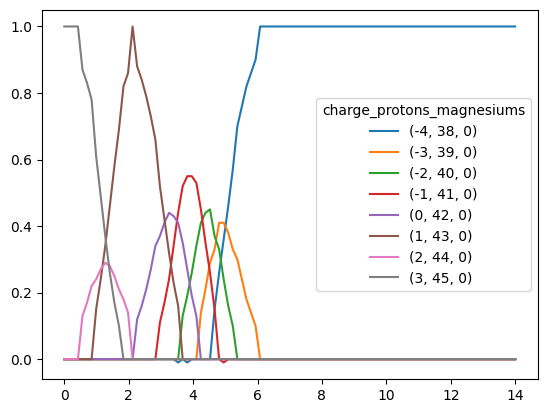

In [17]:
df = thermo_flux.tools.drg_tools.pka_graph(tmodel.metabolites.hydroxybutanoyl_COA_c, pMg = Q_(3,''), ionic_strength = Q_(0.25, 'M'), temperature = Q_(298.15,'K'), accuracy=0.1, round_dp=2) 
#accuracy ignore species <10% abundant, round_dp rounds to decimal places and then renormalises 
df.plot()

<Axes: >

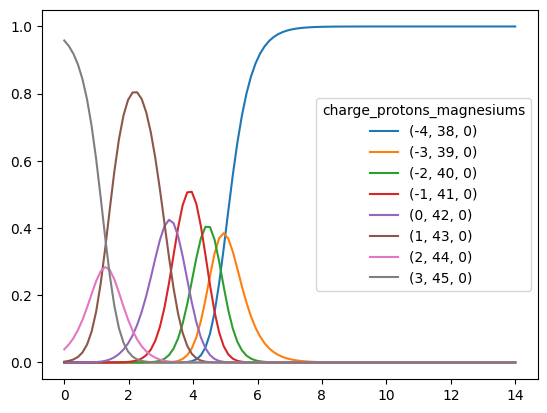

In [18]:
df = thermo_flux.tools.drg_tools.pka_graph(tmodel.metabolites.hydroxybutanoyl_COA_c, pMg = Q_(3,''), ionic_strength = Q_(0.25, 'M'), temperature = Q_(298.15,'K'), accuracy=0.0, round_dp=False) 
df.plot()

In [19]:
# !pip install cvxpy

In [20]:
import pandas as pd

In [21]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 862/862 hydroxybutanoate_c                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Estimating dfG0'...
[████████████████████████████████████████] 862/862 hydroxybutanoate_c                                                                                                                                                                             

Estimating drG0'...


/home/corinna/Documents/thermo_flux_test/thermoflux2/thermo_flux/thermo_flux/core/model.py:168: UserWarning: Allantoin_tx is not balanced and could not be automatically balanced, please check reaction stoichiometry
  drg_transport, dg_protons, dg_electrostatic = drg_tools.calc_drGtransport(rxn,  round_dp = round_dp)


/home/corinna/Documents/thermo_flux_test/thermoflux2/thermo_flux/thermo_flux/core/model.py:168: UserWarning: Allantoin_ec is not balanced and could not be automatically balanced, please check reaction stoichiometry
  drg_transport, dg_protons, dg_electrostatic = drg_tools.calc_drGtransport(rxn,  round_dp = round_dp)


[████████████████████████████████████████] 1013/1013 hydroxybutyrate_CoA_ligase_c                      



In [22]:
tmodel

Name,PlantCoreMetabolism_v2_1_0
Memory address,7f4096501a50
Number of metabolites,862
Number of reactions,1013
Number of genes,0
Number of groups,208
Objective expression,1.0*Phloem_output_tx - 1.0*Phloem_output_tx_reverse_990b1
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Extracellular, Thylakoid, Mitochondrial intermembrane space, Mitochondrion innermembrane interacting with cristal space"


In [23]:
#concentration data all in M 
ConcLimits_df = pd.read_excel('plant_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    if met.id[:-2] in list(ConcLimits_df.index):
        if met.id[:-2] not in ['charge', 'PROTON']:
            ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'M')
            met.lower_bound = Q_(lb,'M')

In [24]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [25]:
bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95) 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 1013/1013 hydroxybutyrate_CoA_ligase_c                                                                                                  



In [26]:
bounds_df.T["hydroxybutyrate_CoA_ligase_c"]

lb   -259.934084
ub    -14.769097
Name: hydroxybutyrate_CoA_ligase_c, dtype: float64

In [27]:
thermo_flux.tools.drg_tools.calc_model_drG0(tmodel)

Magnitude,[0.0 0.0 0.0 ... 3116.4853615622974 0.0 -216.6533567792951]
Units,kilojoule/mole


In [28]:
tmodel.pMg

{'m': 3 <Unit('dimensionless')>,
 'c': 3 <Unit('dimensionless')>,
 'b': 3 <Unit('dimensionless')>,
 'p': 3 <Unit('dimensionless')>,
 'v': 3 <Unit('dimensionless')>,
 'x': 3 <Unit('dimensionless')>,
 'r': 3 <Unit('dimensionless')>,
 'e': 3 <Unit('dimensionless')>,
 'l': 3 <Unit('dimensionless')>,
 'i': 3 <Unit('dimensionless')>,
 'mi': 3 <Unit('dimensionless')>}

# CETCH cycle

In [29]:
model = cobra.io.read_sbml_model(r"CETCH_cycle_exchange.xml")
model.objective = model.reactions.MALSYN_RXN
sol = model.optimize()
model.summary(sol)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Metabolite,Reaction,Flux,C-Number,C-Flux
ACETYL_COA,ACETYL_COA_tx,250,23,19.33%
ATP,ATP_tx,250,10,8.40%
CARBON_DIOXIDE,CO2_tx,500,1,1.68%
NADPH,NADPH_tx,1000,21,70.59%
OXYGEN_MOLECULE,OXYGEN_MOLECULE_tx,500,0,0.00%
PROTON,PROTON_tx,250,0,0.00%
WATER,WATER_tx,250,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ADP,ADP_tx,-250,10,8.40%
CO_A,CO_A_tx,-250,21,17.65%


In [30]:
tmodel = ThermoModel(model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [31]:
tmodel

Name,
Memory address,7f4091d86710
Number of metabolites,28
Number of reactions,27
Number of genes,0
Number of groups,0
Objective expression,1.0*MALSYN_RXN - 1.0*MALSYN_RXN_reverse_25886
Compartments,u


In [32]:
tmodel.metabolites

[<ThermoMetabolite GLYOX at 0x7f4091d86a40>,
 <ThermoMetabolite WATER at 0x7f4091d86e90>,
 <ThermoMetabolite ACETYL_COA at 0x7f4091d87340>,
 <ThermoMetabolite PROTON at 0x7f4091d86560>,
 <ThermoMetabolite MAL at 0x7f4091d874c0>,
 <ThermoMetabolite CO_A at 0x7f4091d87460>,
 <ThermoMetabolite ATP at 0x7f4091d874f0>,
 <ThermoMetabolite 4_HYDROXY_BUTYRATE at 0x7f4091d87520>,
 <ThermoMetabolite 4_HYDROXY_BUTYRYL_COA at 0x7f4091d87550>,
 <ThermoMetabolite ADP at 0x7f4091d87580>,
 <ThermoMetabolite Pi at 0x7f4091d875b0>,
 <ThermoMetabolite NADP at 0x7f4091d875e0>,
 <ThermoMetabolite NADPH at 0x7f4091d87610>,
 <ThermoMetabolite SUCC_S_ALD at 0x7f4091d87640>,
 <ThermoMetabolite OXYGEN_MOLECULE at 0x7f4091d87670>,
 <ThermoMetabolite CPD_9407 at 0x7f4091d876a0>,
 <ThermoMetabolite CPD_9408 at 0x7f4091d876d0>,
 <ThermoMetabolite HYDROGEN_PEROXIDE at 0x7f4091d87700>,
 <ThermoMetabolite PROPIONYL_COA at 0x7f4091d87730>,
 <ThermoMetabolite ACRYLYL_COA at 0x7f4091d87760>,
 <ThermoMetabolite CPD_9406 a

In [33]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3),
 'u': Q_(7.0)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [34]:
tmodel.metabolites.GLYOX.annotation

{'biocyc': 'META:GLYOX',
 'synonyms': ['glyoxalate', 'glyox', 'glyoxylic acid'],
 'delta_G_f(kcal': 'mol)/-102.04095',
 'inchikey': 'HHLFWLYXYJOTON-UHFFFAOYSA-M',
 'InChI': 'InChI=1S/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)/p-1',
 'molecular_weight(daltons)': '73.028'}

In [35]:
tmodel.metabolites.GLYOX.annotation ={'biocyc': 'META:GLYOX',
 'metacyc.compound': 'GLYOX',
 'bigg.metabolite': 'glx',
 'chebi': 'CHEBI:16891',
 'envipath': '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/cdffdb1a-3322-4cc1-9171-d857bfaa198a',
 'hmdb': 'HMDB00119',
 'kegg': 'C00048',
 'reactome': '389678.0',
 'sabiork.compound': '1838.0',
 'seed': 'cpd00040',
 'metanetx.chemical': 'MNXM89656',
 'synonyms': 'Glyoxylate',
 'inchi': 'InChI=1/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)/p-1/fC2HO3/q-1'}

In [36]:
tmodel.metabolites.GLYOX.annotation ={'biocyc': 'META:GLYOX',
 'inchi': 'InChI=1S/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)/p-1',
 'molecular_weight(daltons)': '73.028',
 'kegg': 'C00048'}



In [37]:
for met in tmodel.metabolites:
    
    met_cmp= met.annotation["biocyc"].replace("META:","")
    met.annotation = {"metacyc.compound":met_cmp}
    

In [38]:
for met in tmodel.metabolites:
    print(met.annotation)

{'metacyc.compound': 'GLYOX'}
{'metacyc.compound': 'WATER'}
{'metacyc.compound': 'ACETYL-COA'}
{'metacyc.compound': 'PROTON'}
{'metacyc.compound': 'MAL'}
{'metacyc.compound': 'CO-A'}
{'metacyc.compound': 'ATP'}
{'metacyc.compound': '4-HYDROXY-BUTYRATE'}
{'metacyc.compound': '4-HYDROXY-BUTYRYL-COA'}
{'metacyc.compound': 'ADP'}
{'metacyc.compound': 'Pi'}
{'metacyc.compound': 'NADP'}
{'metacyc.compound': 'NADPH'}
{'metacyc.compound': 'SUCC-S-ALD'}
{'metacyc.compound': 'OXYGEN-MOLECULE'}
{'metacyc.compound': ' CPD-9407'}
{'metacyc.compound': 'CPD-9408'}
{'metacyc.compound': 'HYDROGEN-PEROXIDE'}
{'metacyc.compound': 'PROPIONYL-COA'}
{'metacyc.compound': 'ACRYLYL-COA'}
{'metacyc.compound': 'CPD-9406'}
{'metacyc.compound': 'CROTONYL-COA'}
{'metacyc.compound': ' CARBON-DIOXIDE'}
{'metacyc.compound': 'CPD-17635'}
{'metacyc.compound': 'CPD-9409'}
{'metacyc.compound': ' METHYL-MALONYL-COA'}
{'metacyc.compound': 'SUC-COA'}
{'metacyc.compound': 'CPD-226'}


In [39]:
thermo_flux.tools.drg_tools.get_suitable_ids(tmodel.metabolites.GLYOX)

Initilizing component contribution object...
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from _compound.sqlite


(Compound(id=66, inchi_key=HHLFWLYXYJOTON-UHFFFAOYSA-M), {}, None, None, False)

In [40]:
tmodel.metabolites.CPD_9407.annotation = {'metacyc.compound': 'CPD-9407'}#, 'kegg': 'C18324'}
tmodel.metabolites.METHYL_MALONYL_COA.annotation = {'metacyc.compound': 'METHYL-MALONYL-COA'}#, 'kegg': 'C01213'}
tmodel.metabolites.CARBON_DIOXIDE.annotation = {'metacyc.compound': 'CARBON-DIOXIDE'}

In [41]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

[████████████████████████████████████████] 28/28 CPD_226                              



[]

In [42]:
#concentration data all in M 
ConcLimits_df = pd.read_excel('cetch_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'M')
            met.lower_bound = Q_(lb,'M')
            print(met.id)

GLYOX
WATER
ACETYL_COA
MAL
CO_A
ATP
4_HYDROXY_BUTYRATE
4_HYDROXY_BUTYRYL_COA
ADP
Pi
NADP
NADPH
SUCC_S_ALD
OXYGEN_MOLECULE
CPD_9407
CPD_9408
HYDROGEN_PEROXIDE
PROPIONYL_COA
ACRYLYL_COA
CPD_9406
CROTONYL_COA
CARBON_DIOXIDE
CPD_17635
CPD_9409
METHYL_MALONYL_COA
SUC_COA
CPD_226


In [108]:
for rxn in tmodel.reactions:
    print(rxn)

MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON
RXN_8961: CPD_9409 <=> GLYOX + PROPIONYL_COA
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA <=> ACRYLYL_COA + HYDROGEN_PEROXIDE
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADH <=> METHYL_MALONYL_COA + NAD
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA <=> SUC_COA
RXN_8891: CO_A + NAD + SUCC_S_ALD <=> NADH + PROTON + SUC_COA
RXN_11002: NADH + PROTON + SUCC_S_ALD <=> 4_HYDROXY_BUTYRATE + NAD
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A <=> 4_HYDROXY_BUTYRYL_COA + ADP + Pi
RXN_8890: 4_HYDROXY_BUTYRYL_COA <=> CROTONYL_COA + WATER
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADH <=> CPD_9406 + NAD
RXN_16391: CPD_9406 <=> CPD_17635
RXN_8958: CPD_17635 <=> CPD_9407
RXN_18381: CPD_9407 + OXYGEN_MOLECULE <=> CPD_9408 + HYDROGEN_PEROXIDE
RXN_8960: CPD_9409 <=> CPD_9408 + WATER
MAL_tx:  <=> MAL
CO2_tx:  <=> CARBON_DIOXIDE
ACETYL_COA_tx:  <=> ACETYL_COA
ATP_tx:  <=> ATP
ADP_tx:  <=> ADP
NADPH_tx:  <=> NADH
NADP_tx:  <=> NAD
PROTON_tx:  <=> PROTO

In [43]:
tmodel.compartments

{'u': ''}

In [44]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 28/28 CPD_226                              

Estimating dfG0'...
[████████████████████████████████████████] 30/30 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [45]:
# for met in tmodel.metabolites:
#     met.lower_bound = Q_(1,'mM')
#     met.upper_bound = Q_(1,'mM')

In [46]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [47]:
bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95) 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [48]:
tmodel._rmse_inf

3000 <Unit('kilojoule / mole')>

In [49]:
for rxn in tmodel.reactions:
    print(rxn.id, rxn.drG_SE)

MALSYN_RXN 2.081758617438947 kilojoule / mole
RXN_8961 3.0140600870424894 kilojoule / mole
RXN_15977 5.308282697132137 kilojoule / mole
RXN_18384 4.380841802160132 kilojoule / mole
METHYLMALONYL_COA_MUT_RXN 2.073145691421793 kilojoule / mole
RXN_8891 2.741059699994797 kilojoule / mole
RXN_11002 1.7074524659665746 kilojoule / mole
RXN_18387 1.8761154422533108 kilojoule / mole
RXN_8890 2.4371689046283436 kilojoule / mole
RXN_8957 3.993568120529032 kilojoule / mole
RXN_16391 3.697785493223493e-32 kilojoule / mole
RXN_8958 4.529975766397789e-16 kilojoule / mole
RXN_18381 4.48987935776239 kilojoule / mole
RXN_8960 1.9030338036478547 kilojoule / mole
MAL_tx 0.9873559681976731 kilojoule / mole
CO2_tx 2.9318707535840742 kilojoule / mole
ACETYL_COA_tx 7.826810198529089 kilojoule / mole
ATP_tx 1.4899855434834717 kilojoule / mole
ADP_tx 1.225790908474294 kilojoule / mole
NADPH_tx 6.829013246048599 kilojoule / mole
NADP_tx 6.831885021911919 kilojoule / mole
PROTON_tx 0.0 kilojoule / mole
HYDROGEN_

In [50]:
for rxn in tmodel.reactions:
    print(rxn.id, rxn.drG_SE.to('kcal/mol'))

MALSYN_RXN 0.497552250821928 kilocalorie / mole
RXN_8961 0.7203776498667517 kilocalorie / mole
RXN_15977 1.2687100136549083 kilocalorie / mole
RXN_18384 1.0470463198279474 kilocalorie / mole
METHYLMALONYL_COA_MUT_RXN 0.49549371209889886 kilocalorie / mole
RXN_8891 0.6551289913945499 kilocalorie / mole
RXN_11002 0.40809093354841647 kilocalorie / mole
RXN_18387 0.4484023523549978 kilocalorie / mole
RXN_8890 0.5824973481425295 kilocalorie / mole
RXN_8957 0.9544856884629617 kilocalorie / mole
RXN_16391 8.83791943887068e-33 kilocalorie / mole
RXN_8958 1.0826901927336972e-16 kilocalorie / mole
RXN_18381 1.0731069210713169 kilocalorie / mole
RXN_8960 0.4548359951357205 kilocalorie / mole
MAL_tx 0.23598374000900407 kilocalorie / mole
CO2_tx 0.700733927720859 kilocalorie / mole
ACETYL_COA_tx 1.8706525331092467 kilocalorie / mole
ATP_tx 0.3561150916547494 kilocalorie / mole
ADP_tx 0.2929710584307586 kilocalorie / mole
NADPH_tx 1.6321733379657262 kilocalorie / mole
NADP_tx 1.6328597088699615 kilo

In [51]:
for met in tmodel.metabolites:
    if met.dfG_SE >= tmodel._rmse_inf:
        print(met.id, met.dfG_SE, met.annotation)

charge_u 3000.0 kilojoule / mole {}


In [52]:
tmodel.metabolites.CPD_9407.compound.identifiers

[CompoundIdentifier(registry=Registry(namespace=chebi), accession=CHEBI:81672),
 CompoundIdentifier(registry=Registry(namespace=chebi), accession=CHEBI:84866),
 CompoundIdentifier(registry=Registry(namespace=kegg), accession=C18324),
 CompoundIdentifier(registry=Registry(namespace=metacyc.compound), accession=CPD-9407),
 CompoundIdentifier(registry=Registry(namespace=seed), accession=cpd19589),
 CompoundIdentifier(registry=Registry(namespace=metanetx.chemical), accession=MNXM5823),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=(2S)-methylsuccinyl-CoA),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=(2S)-methylsuccinyl-coenzyme A),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=Methylsuccinyl-CoA),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=Methylsuccinyl-coenzyme A),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=OUFHQHVVFSERRI-VKBDFPRVSA-N),
 CompoundIdentifier(registry=R

In [53]:
tmodel.reactions[0].drG0prime

-35.811333743200976 <Unit('kilojoule / mole')>

In [54]:
for rxn in tmodel.reactions:
    print(rxn.id, rxn.drGmprime.to('kcal/mol'), rxn.drG_SE.to('kcal/mol'))

MALSYN_RXN -4.468569839502854 kilocalorie / mole 0.497552250821928 kilocalorie / mole
RXN_8961 -0.49360430183069526 kilocalorie / mole 0.7203776498667517 kilocalorie / mole
RXN_15977 -17.177014785142386 kilocalorie / mole 1.2687100136549083 kilocalorie / mole
RXN_18384 -5.669564096372622 kilocalorie / mole 1.0470463198279474 kilocalorie / mole
METHYLMALONYL_COA_MUT_RXN -1.9965264980934827 kilocalorie / mole 0.49549371209889886 kilocalorie / mole
RXN_8891 1.4475355473939144 kilocalorie / mole 0.6551289913945499 kilocalorie / mole
RXN_11002 0.12259569656085906 kilocalorie / mole 0.40809093354841647 kilocalorie / mole
RXN_18387 -3.8912020636719005 kilocalorie / mole 0.4484023523549978 kilocalorie / mole
RXN_8890 -6.684621090455249 kilocalorie / mole 0.5824973481425295 kilocalorie / mole
RXN_8957 -5.43395753440906 kilocalorie / mole 0.9544856884629617 kilocalorie / mole
RXN_16391 3.570950243937794e-16 kilocalorie / mole 8.83791943887068e-33 kilocalorie / mole
RXN_8958 0.0 kilocalorie / mol

In [55]:
for rxn in tmodel.reactions:

    print(rxn.id, rxn.drGmprime.to('kcal/mol'), rxn.drG_SE.to('kcal/mol'))

MALSYN_RXN -4.468569839502854 kilocalorie / mole 0.497552250821928 kilocalorie / mole
RXN_8961 -0.49360430183069526 kilocalorie / mole 0.7203776498667517 kilocalorie / mole
RXN_15977 -17.177014785142386 kilocalorie / mole 1.2687100136549083 kilocalorie / mole
RXN_18384 -5.669564096372622 kilocalorie / mole 1.0470463198279474 kilocalorie / mole
METHYLMALONYL_COA_MUT_RXN -1.9965264980934827 kilocalorie / mole 0.49549371209889886 kilocalorie / mole
RXN_8891 1.4475355473939144 kilocalorie / mole 0.6551289913945499 kilocalorie / mole
RXN_11002 0.12259569656085906 kilocalorie / mole 0.40809093354841647 kilocalorie / mole
RXN_18387 -3.8912020636719005 kilocalorie / mole 0.4484023523549978 kilocalorie / mole
RXN_8890 -6.684621090455249 kilocalorie / mole 0.5824973481425295 kilocalorie / mole
RXN_8957 -5.43395753440906 kilocalorie / mole 0.9544856884629617 kilocalorie / mole
RXN_16391 3.570950243937794e-16 kilocalorie / mole 8.83791943887068e-33 kilocalorie / mole
RXN_8958 0.0 kilocalorie / mol

In [56]:
tmodel.reactions.MALSYN_RXN.drGmprime.m

-18.696496208479942

In [57]:
tmodel.reactions.MALSYN_RXN.drGmprime.m_as('kcal/mol')

-4.468569839502854

In [58]:
drGmprime_df = pd.DataFrame(columns=['reaction','drGmprime','drG_SE'])
df_list = []

for rxn in tmodel.reactions:
    data ={'reaction':rxn.id, 'drGmprime':rxn.drGmprime.m_as('kcal/mol'), 'drG_SE':rxn.drG_SE.m_as('kcal/mol')}
    df_list.append(pd.DataFrame(data, index=[0]))

drGmprime_df = pd.concat(df_list)


In [59]:
drGmprime_df

,reaction,drGmprime,drG_SE
0,MALSYN_RXN,-4.468570e+00,4.975523e-01
0,RXN_8961,-4.936043e-01,7.203776e-01
0,RXN_15977,-1.717701e+01,1.268710e+00
0,RXN_18384,-5.669564e+00,1.047046e+00
0,METHYLMALONYL_COA_MUT_RXN,-1.996526e+00,4.954937e-01
0,RXN_8891,1.447536e+00,6.551290e-01
0,RXN_11002,1.225957e-01,4.080909e-01
0,RXN_18387,-3.891202e+00,4.484024e-01
0,RXN_8890,-6.684621e+00,5.824973e-01
0,RXN_8957,-5.433958e+00,9.544857e-01


In [60]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_reaction(drGmprime_df, reactions_list):
    # Get the reaction names and drGmprime values
    reactions = drGmprime_df['reaction'].values
    drGmprime = drGmprime_df['drGmprime'].values
    errors = drGmprime_df['drG_SE'].values

    # Filter the reactions based on the provided list
    filtered_reactions = [reaction for reaction in reactions if reaction in reactions_list]
    filtered_drGmprime = [drGmprime[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]
    filtered_errors = [errors[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]

    # Plot the filtered drGmprime values with error bars
    plt.errorbar(filtered_reactions, filtered_drGmprime, yerr=filtered_errors, fmt='o')

    # Set the x-axis label
    plt.xlabel('Reaction')

    # Set the y-axis label
    plt.ylabel('drGmprime')

    # Set the title
    plt.title('drGmprime vs. Reaction')

    # Tilt the x-axis labels by 270 degrees
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()


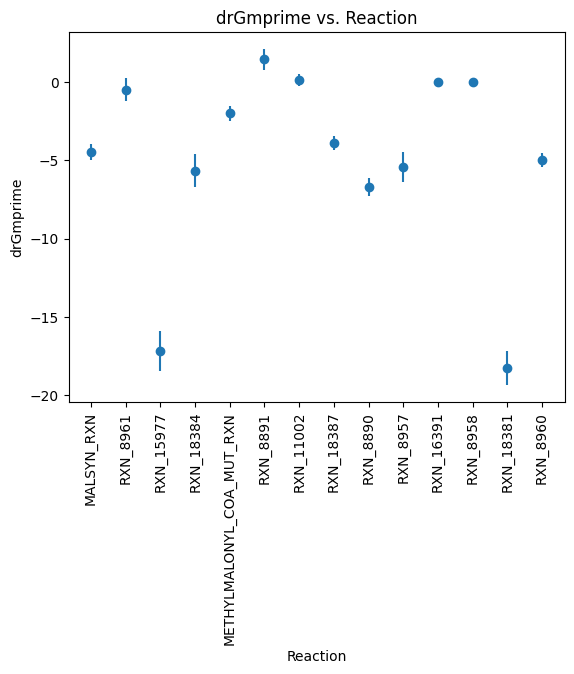

In [61]:
rxn_list1 = [rxn.id for rxn in tmodel.reactions if not rxn.id.endswith("_tx")]

plot_reaction(drGmprime_df, rxn_list1)

In [62]:
thermo_flux.tools.drg_tools.calc_model_drG0(tmodel)

Magnitude,[6.9588450478595405 8.67233616377598 -71.95250154839323 -38.05589005295042 -7.571646229303951 43.858767604056084 -45.98645811939059 -21.483355426267735 -10.195393016173512 -38.990656777847505 0.0 0.0 -76.4269889781367 -3.686422011659033 -841.1781113959644 -386.0000000000019 -3231.0580128140787 -2811.578331958078 -1945.4278989637223 -3070.5260288612576 -3098.931269475794 0.0 -133.98848078973268 16.399999999865035 -3091.7676959124556 -1095.2054811974629 -238.1367122055623]
Units,kilojoule/mole


In [63]:
tmodel.reactions.MALSYN_RXN.drGmprime.to('kcal/mol')

-4.468569839502854 <Unit('kilocalorie / mole')>

In [64]:
Q_(bounds_df.values, 'kJ/mol').to('kcal/mol')


Magnitude,[[-15.668769429416612 6.321170901712158] [-9.557122173020543 8.980372418057918] [-31.487371468596884 -2.8666581016878756] [-20.349986533394077 8.600399475591209] [-8.272226283661299 4.27917328747433] [-10.750676948697608 13.235289194786663] [-8.737026658564265 8.982218051685976] [-16.143625359619836 8.361221232276042] [-14.874873528379426 1.9160901961676546] [-19.528146848730575 8.249772923087246] [-3.1374884112949624 3.137488411294964] [-3.1374884112949633 3.1374884112949633] [-31.337959065085187 -5.19495161008738] [-12.353459945130544 2.8204164166804095] [-169.82176640992023 -163.69507010782056] [-102.14837436145469 -90.13468377585178] [-461.6722423932678 -434.8391836314441] [-556.9238285302677 -549.2754274518613] [-347.48709868571433 -340.6385435729092] [-499.65681303012667 -475.8445721088839] [-514.8124555826416 -490.99152039575654] [6.776895989943239e-13 -6.776895989943239e-13] [-22.439961359535165 -10.426270773932336] [-5.972466139689297 6.041224445913856] [-447.81732711380977 -420.8620227555915] [-259.6044712733421 -254.20023420314823] [-44.042833652921104 -38.60737915740797]]
Units,kilocalorie/mole


In [65]:
Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m.T[0]


array([-1.56687694e+01, -9.55712217e+00, -3.14873715e+01, -2.03499865e+01,
       -8.27222628e+00, -1.07506769e+01, -8.73702666e+00, -1.61436254e+01,
       -1.48748735e+01, -1.95281468e+01, -3.13748841e+00, -3.13748841e+00,
       -3.13379591e+01, -1.23534599e+01, -1.69821766e+02, -1.02148374e+02,
       -4.61672242e+02, -5.56923829e+02, -3.47487099e+02, -4.99656813e+02,
       -5.14812456e+02,  6.77689599e-13, -2.24399614e+01, -5.97246614e+00,
       -4.47817327e+02, -2.59604471e+02, -4.40428337e+01])

In [66]:
bounds_df

,lb,ub
MALSYN_RXN,-6.555813e+01,2.644778e+01
RXN_8961,-3.998700e+01,3.757388e+01
RXN_15977,-1.317432e+02,-1.199410e+01
RXN_18384,-8.514434e+01,3.598407e+01
METHYLMALONYL_COA_MUT_RXN,-3.461099e+01,1.790406e+01
RXN_8891,-4.498083e+01,5.537645e+01
RXN_11002,-3.655572e+01,3.758160e+01
RXN_18387,-6.754493e+01,3.498335e+01
RXN_8890,-6.223647e+01,8.016921e+00
RXN_8957,-8.170577e+01,3.451705e+01


In [67]:
bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m

In [68]:
bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

In [69]:
bounds_df_kcal

,lb,ub
MALSYN_RXN,-1.566877e+01,6.321171e+00
RXN_8961,-9.557122e+00,8.980372e+00
RXN_15977,-3.148737e+01,-2.866658e+00
RXN_18384,-2.034999e+01,8.600399e+00
METHYLMALONYL_COA_MUT_RXN,-8.272226e+00,4.279173e+00
RXN_8891,-1.075068e+01,1.323529e+01
RXN_11002,-8.737027e+00,8.982218e+00
RXN_18387,-1.614363e+01,8.361221e+00
RXN_8890,-1.487487e+01,1.916090e+00
RXN_8957,-1.952815e+01,8.249773e+00


In [70]:
ratio_list = [0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100]

tmodel.metabolites.NADP.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADP.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADPH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)


    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.01 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.2 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.4 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.6 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.8 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

2 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

3 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

4 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

5 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

100 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [71]:
new_compiled_df

,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100
MALSYN_RXN,"[-65.55813129267743, 26.447779052762897]","[-65.55813129267663, 26.447779052762392]","[-65.55813129267699, 26.447779052762343]","[-65.55813129267668, 26.447779052762318]","[-65.55813129267663, 26.4477790527621]","[-65.55813129267801, 26.44777905276225]","[-65.55813129267787, 26.447779052762854]","[-65.55813129267777, 26.447779052762804]","[-65.55813129267787, 26.447779052762847]","[-65.55813129267774, 26.447779052763025]","[-65.55813129267756, 26.447779052762698]"
RXN_8961,"[-39.98699917191418, 37.57387819714994]","[-39.986999171914036, 37.57387819714984]","[-39.98699917191402, 37.57387819714984]","[-39.98699917191398, 37.57387819715001]","[-39.98699917191391, 37.573878197149924]","[-39.98699917191402, 37.57387819714994]","[-39.98699917191388, 37.57387819715004]","[-39.98699917191395, 37.57387819715007]","[-39.98699917191374, 37.573878197149895]","[-39.98699917191378, 37.573878197149995]","[-39.98699917191308, 37.573878197149156]"
RXN_15977,"[-131.74316222465723, -11.994097497414117]","[-131.74316222465805, -11.994097497413826]","[-131.74316222465754, -11.99409749741428]","[-131.7431622246576, -11.994097497413684]","[-131.74316222465754, -11.994097497413456]","[-131.74316222465757, -11.99409749741394]","[-131.7431622246579, -11.994097497414202]","[-131.7431622246576, -11.994097497414252]","[-131.74316222465734, -11.99409749741399]","[-131.7431622246572, -11.994097497414138]","[-131.74316222465535, -11.994097497415908]"
RXN_18384,"[-60.607200453449, 34.266711611036065]","[-68.02950612131202, 26.844405943175502]","[-69.74686594426615, 25.127046120216004]","[-70.75145704093846, 24.122455023542194]","[-71.46422576721977, 23.409686297261004]","[-72.01709214326003, 22.856819921221845]","[-73.73445196621563, 21.139460138902304]","[-74.73904306288962, 20.13486904222837]","[-75.45181178917103, 19.422100315946803]","[-76.00467816521122, 18.869233939906607]","[-83.426983833074, 11.446928272046012]"
METHYLMALONYL_COA_MUT_RXN,"[-34.610994770835376, 17.904061034789017]","[-34.61099477083681, 17.904061034790576]","[-34.61099477083573, 17.904061034789606]","[-34.61099477083574, 17.90406103478942]","[-34.61099477083661, 17.904061034790416]","[-34.61099477083658, 17.90406103479036]","[-34.61099477083671, 17.904061034790445]","[-34.61099477083657, 17.904061034790317]","[-34.610994770836555, 17.904061034790253]","[-34.61099477083648, 17.904061034790388]","[-34.61099477083633, 17.904061034790082]"
RXN_8891,"[-43.26347253042487, 30.839306788433923]","[-35.84116686256189, 38.261612456296284]","[-34.123807039606376, 39.97897227925188]","[-33.11921594293224, 40.98356337592574]","[-32.40644721665078, 41.69633210220738]","[-31.853580840610743, 42.249198478247465]","[-30.136221017654833, 43.9665583012031]","[-29.131629920980874, 44.9711493978771]","[-28.418861194699303, 45.68391812415866]","[-27.8659948186589, 46.23678450019874]","[-20.443689150797073, 53.65909016806214]"
RXN_11002,"[-12.01857633688338, 35.864240505332745]","[-19.440882004747046, 28.44193483747126]","[-21.15824182770189, 26.72457501451479]","[-22.16283292437587, 25.71998391784053]","[-22.875601650657472, 25.00721519155895]","[-23.428468026697537, 24.454348815518756]","[-25.145827849652925, 22.736988992562942]","[-26.1504189463271, 21.732397895888912]","[-26.863187672608547, 21.019629169607317]","[-27.416054048648704, 20.466762793567085]","[-34.838359716510936, 13.044457125704195]"
RXN_18387,"[-67.54492850464916, 34.983349635843055]","[-67.54492850464837, 34.98334963584173]","[-67.54492850464966, 34.983349635843055]","[-67.54492850464945, 34.98334963584299]","[-67.54492850464955, 34.98334963584297]","[-67.54492850464933, 34.98334963584296]","[-67.54492850464949, 34.983349635842906]","[-67.5449285046492, 34.98334963584282]","[-67.54492850464928, 34.98334963584284]","[-67.54492850464925, 34.98334963584258]","[-67.54492850464888, 34.983349635842515]"
RXN_8890,"[-62.23647084273735, 8.016921380763149]","[-62.236470842737134, 8.016921380762579]","

In [72]:
ratio_list = [0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100]

tmodel.metabolites.NADP.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADP.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADPH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.01 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.2 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.4 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.6 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.8 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

2 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

3 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

4 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

5 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

100 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [73]:
new_compiled_df

,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100
MALSYN_RXN,"[-15.66876942941621, 6.321170901711973]","[-15.66876942941602, 6.321170901711852]","[-15.668769429416106, 6.321170901711841]","[-15.668769429416031, 6.3211709017118345]","[-15.66876942941602, 6.321170901711783]","[-15.66876942941635, 6.3211709017118185]","[-15.668769429416317, 6.321170901711963]","[-15.668769429416292, 6.321170901711951]","[-15.668769429416317, 6.3211709017119615]","[-15.668769429416285, 6.321170901712003]","[-15.668769429416242, 6.321170901711926]"
RXN_8961,"[-9.557122173019641, 8.980372418056868]","[-9.557122173019607, 8.980372418056843]","[-9.557122173019604, 8.980372418056843]","[-9.557122173019593, 8.980372418056884]","[-9.557122173019575, 8.980372418056865]","[-9.557122173019604, 8.980372418056868]","[-9.55712217301957, 8.980372418056891]","[-9.557122173019586, 8.9803724180569]","[-9.557122173019534, 8.980372418056858]","[-9.557122173019545, 8.980372418056882]","[-9.557122173019378, 8.980372418056682]"
RXN_15977,"[-31.487371468608323, -2.866658101676414]","[-31.48737146860852, -2.8666581016763444]","[-31.487371468608398, -2.866658101676453]","[-31.48737146860841, -2.8666581016763106]","[-31.487371468608398, -2.866658101676256]","[-31.487371468608405, -2.8666581016763715]","[-31.487371468608483, -2.8666581016764345]","[-31.48737146860841, -2.8666581016764465]","[-31.487371468608348, -2.8666581016763835]","[-31.487371468608316, -2.866658101676419]","[-31.487371468607872, -2.866658101676842]"
RXN_18384,"[-14.485468559619742, 8.189940633612826]","[-16.259442189606123, 6.415967003627031]","[-16.669901038304527, 6.005508154927343]","[-16.91000407288204, 5.765405120349473]","[-17.080359887002814, 5.595049306228729]","[-17.212498122194077, 5.462911071037726]","[-17.622956970892837, 5.05245223205122]","[-17.86306000547075, 4.81234919747332]","[-18.033415819591546, 4.641993383352486]","[-18.165554054782795, 4.509855148161234]","[-19.93952768476912, 2.735881518175433]"
METHYLMALONYL_COA_MUT_RXN,"[-8.272226283660462, 4.2791732874734745]","[-8.272226283660805, 4.279173287473847]","[-8.272226283660547, 4.279173287473615]","[-8.27222628366055, 4.279173287473571]","[-8.272226283660757, 4.279173287473808]","[-8.27222628366075, 4.279173287473795]","[-8.272226283660782, 4.2791732874738155]","[-8.272226283660748, 4.2791732874737844]","[-8.272226283660745, 4.279173287473769]","[-8.272226283660725, 4.279173287473802]","[-8.27222628366069, 4.2791732874737285]"
RXN_8891,"[-10.340218100005943, 7.37077122094501]","[-8.566244470019573, 9.144744850931234]","[-8.155785621320835, 9.55520369962999]","[-7.9156825867428875, 9.795306734207873]","[-7.74532677262208, 9.965662548328723]","[-7.613188537430865, 10.097800783519949]","[-7.202729688732035, 10.508259632218714]","[-6.962626654154128, 10.748362666796629]","[-6.792270840033294, 10.91871848091746]","[-6.660132604841993, 11.050856716108685]","[-4.8861589748558965, 12.824830346095158]"
RXN_11002,"[-2.872508684723561, 8.571759202995397]","[-4.646482314710097, 6.797785573009382]","[-5.056941163408673, 6.387326724310418]","[-5.297044197986584, 6.1472236897324395]","[-5.467400012107426, 5.976867875611603]","[-5.599538247298646, 5.844729640420352]","[-6.0099970959973525, 5.434270791721544]","[-6.25010013057531, 5.194167757143621]","[-6.420455944696115, 5.023811943022781]","[-6.5525941798873575, 4.891673707831521]","[-8.32656780987355, 3.117700077845171]"
RXN_18387,"[-16.14362535961978, 8.361221232276064]","[-16.14362535961959, 8.36122123227575]","[-16.1436253596199, 8.361221232276064]","[-16.143625359619847, 8.36122123227605]","[-16.14362535961987, 8.361221232276044]","[-16.143625359619822, 8.361221232276042]","[-16.143625359619858, 8.361221232276028]","[-16.14362535961979, 8.361221232276009]","[-16.143625359619808, 8.361221232276014]","[-16.1436253596198, 8.36122123227595]","[-16.143625359619712, 8.361221232275936]"
RXN_8890,"[-14.874873528378906, 1.9160901961671004]","[-14.874873528378854, 1.9160901961669643]","[-14.87487352837879, 1.9160901

In [74]:
import pandas as pd
# from pint import Quantity as Q_

def calculate_flux_bounds(tmodel, ratio_list, metabolite):
    """
    Calculate flux bounds for different ratios using the provided model.

    Args:
        tmodel (object): The model object.
        ratio_list (list): List of ratios to iterate over.

    Returns:
        pandas.DataFrame: DataFrame containing the flux bounds for each ratio.
    """
    compiled_df = pd.DataFrame()

    for item in ratio_list:
        try:
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
        except:
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')

        tmodel.m = None  # reset the gurobi model object in case you're re-running this cell 
        tmodel.add_TFBA_variables(gdiss_constraint=False, qnorm=1, error_type='covariance')
        bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)

        # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
        compiled_df.insert(0, str(item) + "_ub", bounds_df.ub, False)
        compiled_df.insert(0, str(item) + "_lb", bounds_df.lb, False)

    new_compiled_df = pd.DataFrame()
    new_compiled_df.index = compiled_df.index

    for value in ratio_list:
        new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

    return new_compiled_df


In [75]:
new_compiled_df = calculate_flux_bounds(tmodel, ratio_list, "NADPH")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [76]:
bounds_df

,lb,ub
MALSYN_RXN,-6.555813e+01,2.644778e+01
RXN_8961,-3.998700e+01,3.757388e+01
RXN_15977,-1.317432e+02,-1.199410e+01
RXN_18384,-8.342698e+01,1.144693e+01
METHYLMALONYL_COA_MUT_RXN,-3.461099e+01,1.790406e+01
RXN_8891,-2.044369e+01,5.365909e+01
RXN_11002,-3.483836e+01,1.304446e+01
RXN_18387,-6.754493e+01,3.498335e+01
RXN_8890,-6.223647e+01,8.016921e+00
RXN_8957,-7.998841e+01,9.979907e+00


In [77]:
import matplotlib.pyplot as plt

def plot_dataframe_values(index_names, dataframe):
    for name in index_names:
        x = dataframe.columns.values

        y_lb = []
        y_ub = []

        for value in range(len(x)):
            y_lb.append(dataframe.loc[name].values[value][0])
            y_ub.append(dataframe.loc[name].values[value][1])

        plt.scatter(x, y_lb, label="lb", color='blue')
        plt.scatter(x, y_ub, label="ub", color='blue')
        plt.fill_between(x, y_lb, y_ub, color='blue', alpha=0.3)

        plt.axhline(0, color='red', linewidth=2)  # Add a thick red line at y=0

        plt.xlabel('Ratios')
        plt.ylabel('drG')
        plt.title(name)
        # plt.legend()
        plt.show()


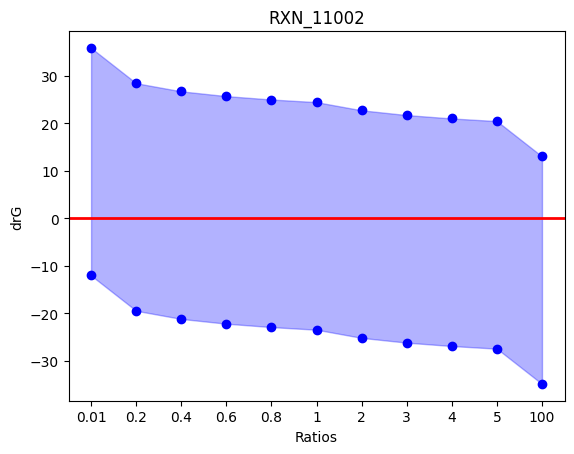

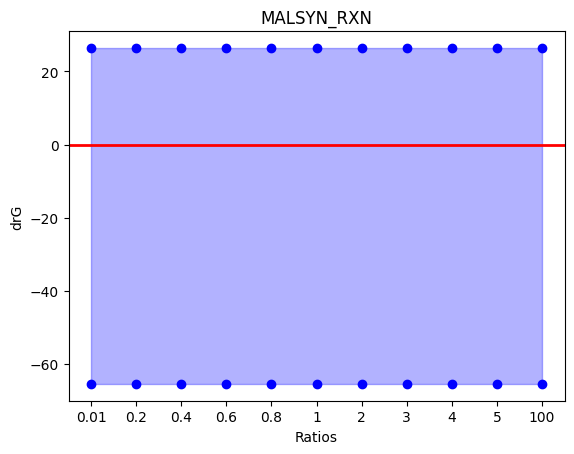

In [78]:
plot_dataframe_values(["RXN_11002", "MALSYN_RXN"], new_compiled_df)

In [79]:
cetch_model_NADH = cobra.io.read_sbml_model(r"CETCH_cycle_exchange.xml")

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


In [80]:
NADH_met = Metabolite("NADH", name="NADH", compartment="u", charge = -2, formula = "C21H27N7O14P2")
NADH_met.annotation = {'biocyc': 'META:NADH',
 'metacyc.compound': 'NADH',
 'bigg.metabolite': 'nadh',
 'chebi': 'CHEBI:16908',
 'hmdb': 'HMDB01487',
 'kegg': 'C00004',
 'reactome': '192305.0',
 'sabiork.compound': '38.0',
 'seed': 'cpd00004',
 'metanetx.chemical': 'MNXM89564',
 'synonyms': 'Nicotinamide adenine dinucleotide - reduced',
 'inchi': 'InChI=1/C21H29N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1,3-4,7-8,10-11,13-16,20-21,29-32H,2,5-6H2,(H2,23,33)(H,34,35)(H,36,37)(H2,22,24,25)/p-2/fC21H27N7O14P2/h22-23H2/q-2'}

NAD_met = Metabolite("NAD", name="NAD", compartment="u", charge = -1, formula = "C21H26N7O14P2")
NAD_met.annotation ={'biocyc': 'META:NAD',
 'metacyc.compound': 'NAD',
 'bigg.metabolite': 'nad',
 'chebi': 'CHEBI:15846',
 'hmdb': 'HMDB00902',
 'kegg': 'C00003',
 'reactome': '113526.0',
 'sabiork.compound': '37.0',
 'seed': 'cpd00003',
 'metanetx.chemical': 'MNXM588016',
 'synonyms': 'Nicotinamide adenine dinucleotide',
 'inchi': 'InChI=1/C21H27N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1-4,7-8,10-11,13-16,20-21,29-32H,5-6H2,(H5-,22,23,24,25,33,34,35,36,37)/p-1/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O14P2/h22-23H2/q-1'}

cetch_model_NADH.add_metabolites([NADH_met, NAD_met])


for rxn in cetch_model_NADH.reactions:
    if "NADPH" in [met.id for met in rxn.metabolites]:
        print(rxn.id)
        try:
            rxn.add_metabolites({cetch_model_NADH.metabolites.NADH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*1,
                                 cetch_model_NADH.metabolites.NAD:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*1})
            
            rxn.add_metabolites({cetch_model_NADH.metabolites.NADPH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*-1,
                                 cetch_model_NADH.metabolites.NADP:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*-1})
        except:
            pass



RXN_18384
RXN_8891
RXN_11002
RXN_8957
NADPH_tx


In [81]:
cetch_model_NADH.reactions.NADPH_tx.metabolites

{<Metabolite NADPH at 0x7f40809d9510>: 1.0}

In [82]:
rxn = cetch_model_NADH.reactions.NADPH_tx

rxn.add_metabolites({cetch_model_NADH.metabolites.NADH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*1})

rxn.add_metabolites({cetch_model_NADH.metabolites.NADPH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*-1})

In [83]:
rxn = cetch_model_NADH.reactions.NADP_tx

rxn.add_metabolites({cetch_model_NADH.metabolites.NAD:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*1})

rxn.add_metabolites({cetch_model_NADH.metabolites.NADP:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*-1})

In [84]:
cetch_model_NADH.reactions.NADP_tx

Reaction identifier,NADP_tx
Name,NADP exchange
Memory address,0x7f40809da680
Stoichiometry,<=> NAD <=> NAD
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [85]:
cetch_model_NADH.objective = cetch_model_NADH.reactions.MALSYN_RXN
sol = cetch_model_NADH.optimize()
cetch_model_NADH.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
ACETYL_COA,ACETYL_COA_tx,250,23,19.33%
ATP,ATP_tx,250,10,8.40%
CARBON_DIOXIDE,CO2_tx,500,1,1.68%
NADH,NADPH_tx,1000,21,70.59%
OXYGEN_MOLECULE,OXYGEN_MOLECULE_tx,500,0,0.00%
PROTON,PROTON_tx,250,0,0.00%
WATER,WATER_tx,250,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ADP,ADP_tx,-250,10,8.40%
CO_A,CO_A_tx,-250,21,17.65%


In [86]:
tmodel = ThermoModel(cetch_model_NADH, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [87]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3),
    'u': Q_(7.0)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [88]:
for met in tmodel.metabolites:
    
    met_cmp= met.annotation["biocyc"].replace("META:","")
    met.annotation = {"metacyc.compound":met_cmp}

tmodel.metabolites.CPD_9407.annotation = {'metacyc.compound': 'CPD-9407'}#, 'kegg': 'C18324'}
tmodel.metabolites.METHYL_MALONYL_COA.annotation = {'metacyc.compound': 'METHYL-MALONYL-COA'}#, 'kegg': 'C01213'}
tmodel.metabolites.CARBON_DIOXIDE.annotation = {'metacyc.compound': 'CARBON-DIOXIDE'}

In [89]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = False)

Initilizing component contribution object.../30 GLYOX                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from _compound.sqlite
[████████████████████████████████████████] 30/30 NAD                                  



[]

In [90]:
#concentration data all in M 
ConcLimits_df = pd.read_excel('cetch_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'M')
            met.lower_bound = Q_(lb,'M')
            print(met.id)

GLYOX
WATER
ACETYL_COA
MAL
CO_A
ATP
4_HYDROXY_BUTYRATE
4_HYDROXY_BUTYRYL_COA
ADP
Pi
NADP
NADPH
SUCC_S_ALD
OXYGEN_MOLECULE
CPD_9407
CPD_9408
HYDROGEN_PEROXIDE
PROPIONYL_COA
ACRYLYL_COA
CPD_9406
CROTONYL_COA
CARBON_DIOXIDE
CPD_17635
CPD_9409
METHYL_MALONYL_COA
SUC_COA
CPD_226
NADH
NAD


In [91]:
tmodel.I

{'u': 0.25 <Unit('molar')>}

In [92]:
tmodel.metabolites.GLYOX.compound.can_be_transformed()

True

In [93]:
tmodel.compartments

{'u': ''}

In [94]:
tmodel.pMg

{'u': 3 <Unit('dimensionless')>}

In [95]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3),
    'u': Q_(7.0)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

# pH = tmodel.pH
# I = tmodel.I
# T = tmodel.T
# pMg = tmodel.pMg

# tmodel.metabolites.GLYOX.compound.transform(pH, I, T, pMg)

In [96]:
# tmodel.pMg = {'u':Q_(3,'M')}

In [97]:
tmodel

Name,
Memory address,7f40809cee00
Number of metabolites,30
Number of reactions,27
Number of genes,0
Number of groups,0
Objective expression,1.0*MALSYN_RXN - 1.0*MALSYN_RXN_reverse_25886
Compartments,u


In [98]:
for met in tmodel.metabolites:
    print(met.id, met.compartment)

GLYOX u
WATER u
ACETYL_COA u
PROTON u
MAL u
CO_A u
ATP u
4_HYDROXY_BUTYRATE u
4_HYDROXY_BUTYRYL_COA u
ADP u
Pi u
NADP u
NADPH u
SUCC_S_ALD u
OXYGEN_MOLECULE u
CPD_9407 u
CPD_9408 u
HYDROGEN_PEROXIDE u
PROPIONYL_COA u
ACRYLYL_COA u
CPD_9406 u
CROTONYL_COA u
CARBON_DIOXIDE u
CPD_17635 u
CPD_9409 u
METHYL_MALONYL_COA u
SUC_COA u
CPD_226 u
NADH u
NAD u


In [99]:
thermo_flux.tools.drg_tools.calc_dfG_transform(tmodel.metabolites.GLYOX)

39.932987600843894 <Unit('kilojoule / mole')>

In [100]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 30/30 NAD                                  

Estimating dfG0'...
[████████████████████████████████████████] 32/32 Mg_u                                                  

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [101]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [102]:
bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95) 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [103]:
import matplotlib.pyplot as plt

def plot_reaction(drGmprime_df, reactions_list):
    # Get the reaction names and drGmprime values
    reactions = drGmprime_df['reaction'].values
    drGmprime = drGmprime_df['drGmprime'].values
    errors = drGmprime_df['drG_SE'].values

    # Filter the reactions based on the provided list
    filtered_reactions = [reaction for reaction in reactions if reaction in reactions_list]
    filtered_drGmprime = [drGmprime[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]
    filtered_errors = [errors[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]

    # Plot the filtered drGmprime values with error bars
    plt.errorbar(filtered_reactions, filtered_drGmprime, yerr=filtered_errors, fmt='o')

    # Set the x-axis label
    plt.xlabel('Reaction')

    # Set the y-axis label
    plt.ylabel('drGmprime')

    # Set the title
    plt.title('drGmprime vs. Reaction')

    # Tilt the x-axis labels by 270 degrees
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()


In [104]:
import matplotlib.pyplot as plt

def plot_dataframe_values(index_names, dataframe):
    for name in index_names:
        x = dataframe.columns.values

        y_lb = []
        y_ub = []

        for value in range(len(x)):
            y_lb.append(dataframe.loc[name].values[value][0])
            y_ub.append(dataframe.loc[name].values[value][1])

        plt.scatter(x, y_lb, label="lb", color='blue')
        plt.scatter(x, y_ub, label="ub", color='blue')
        plt.fill_between(x, y_lb, y_ub, color='blue', alpha=0.3)

        plt.axhline(0, color='red', linewidth=2)  # Add a thick red line at y=0

        plt.xlabel('Ratios')
        plt.ylabel('drG')
        plt.title(name)
        # plt.legend()
        plt.show()


In [105]:
import pandas as pd
# from pint import Quantity as Q_

def calculate_flux_bounds(tmodel, ratio_list, metabolite):
    """
    Calculate flux bounds for different ratios using the provided model.

    Args:
        tmodel (object): The model object.
        ratio_list (list): List of ratios to iterate over.

    Returns:
        pandas.DataFrame: DataFrame containing the flux bounds for each ratio.
    """
    compiled_df = pd.DataFrame()

    for item in ratio_list:
        try:
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
        except:
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')

        tmodel.m = None  # reset the gurobi model object in case you're re-running this cell 
        tmodel.add_TFBA_variables(gdiss_constraint=False, qnorm=1, error_type='covariance')
        bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)

        # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
        compiled_df.insert(0, str(item) + "_ub", bounds_df.ub, False)
        compiled_df.insert(0, str(item) + "_lb", bounds_df.lb, False)

    new_compiled_df = pd.DataFrame()
    new_compiled_df.index = compiled_df.index

    for value in ratio_list:
        new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

    return new_compiled_df



In [106]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000]

tmodel.metabolites.NAD.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NAD.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NAPH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

AttributeError: DictList has no attribute or entry NAPH

In [ ]:
calculate_flux_bounds(tmodel, ratio_list, "NADH")

In [ ]:
new_compiled_df = calculate_flux_bounds(tmodel, ratio_list, "NADH")

In [ ]:
plot_dataframe_values(["RXN_11002", "RXN_18384", "RXN_8891", "RXN_8957", "MALSYN_RXN"], new_compiled_df)

In [ ]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')